Imports


In [2]:
import torch 
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader 
from torchsummary import summary
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder

device = 'cuda' if torch.cuda.is_available() else 'cpu'

Dataset

In [3]:
data_df = pd.read_csv('riceClassification.csv')

#dropping the nulls & not required columns
data_df.dropna(inplace = True)
data_df.drop(['id'], axis = 1, inplace = True)

#checking total unique classes
print('Unique classes: ',data_df['Class'].unique())
print(data_df.shape)

le = LabelEncoder()
data_df['Class'] = le.fit_transform(data_df['Class'])
data_df.head()

Unique classes:  [1 0]
(18185, 11)


,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,EquivDiameter,Extent,Perimeter,Roundness,AspectRation,Class
0,4537,92.229316,64.012769,0.719916,4677,76.004525,0.657536,273.085,0.764510,1.440796,1
1,2872,74.691881,51.400454,0.725553,3015,60.471018,0.713009,208.317,0.831658,1.453137,1
2,3048,76.293164,52.043491,0.731211,3132,62.296341,0.759153,210.012,0.868434,1.465950,1
3,3073,77.033628,51.928487,0.738639,3157,62.551300,0.783529,210.657,0.870203,1.483456,1
4,3693,85.124785,56.374021,0.749282,3802,68.571668,0.769375,230.332,0.874743,1.510000,1


Data Preprocessing

In [ ]:
orignal_df = data_df.copy() 

for column in data_df.columns:
  data_df[column] = data_df[column]/data_df[column].abs().max()
data_df.head()

,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,EquivDiameter,Extent,Perimeter,Roundness,AspectRation,Class
0,0.444368,0.503404,0.775435,0.744658,0.424873,0.666610,0.741661,0.537029,0.844997,0.368316,1.0
1,0.281293,0.407681,0.622653,0.750489,0.273892,0.530370,0.804230,0.409661,0.919215,0.371471,1.0
2,0.298531,0.416421,0.630442,0.756341,0.284520,0.546380,0.856278,0.412994,0.959862,0.374747,1.0
3,0.300979,0.420463,0.629049,0.764024,0.286791,0.548616,0.883772,0.414262,0.961818,0.379222,1.0
4,0.361704,0.464626,0.682901,0.775033,0.345385,0.601418,0.867808,0.452954,0.966836,0.386007,1.0


Data Splitting

In [10]:
x = np.array(data_df.iloc[:, : -1])
y = np.array(data_df.iloc[:, -1])

x_train, x_test, y_train, y_test = train_test_split(x,y, test_size = 0.3)
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size = 0.5)

print('Training set is: ', x_train.shape[0], "rows which is", round(x_train.shape[0]/x.shape[0],4)*100, "%")
print('Testing set is: ', x_test.shape[0],'rows which is', round(x_test.shape[0]/x.shape[0],4)*100, "%")
print('Validation is: ', x_val.shape[0],' rows which is ', round(x_val.shape[0]/x.shape[0],4)*100, "%")
type(x_train)  # Will tell you the exact type: np.ndarray or pd.DataFrame


Training set is:  12729 rows which is 70.0 %
Testing set is:  2728 rows which is 15.0 %
Validation is:  2728  rows which is  15.0 %


numpy.ndarray

Dataset Object

In [6]:
class dataset(Dataset):
  def __init__(self, x, y):
    self.x = torch.tensor(x, dtype = torch.float32).to(device)
    self.y = torch.tensor(y, dtype = torch.float32).to(device)

  def __len__(self):
    return len(self.x)
  
  def __getitem__(self, index):
    return self.x[index], self.y[index]

training_data = dataset(x_train, y_train)
validation_data = dataset(x_val, y_val)
testing_data = dataset(x_test, y_test)

Training Hyper Parameters

In [7]:
BATCH_SIZE = 32
EPOCHS = 50
HIDDEN_NEURONS = 10
LR = 1e-2

Data Loader

In [9]:

train_dataloader = DataLoader(training_data, batch_size=BATCH_SIZE, shuffle= True)
validation_dataloader = DataLoader(validation_data, batch_size=BATCH_SIZE, shuffle= True)
testing_dataloader = DataLoader(testing_data, batch_size=BATCH_SIZE, shuffle= True)
train_dataloader
     

Model class

In [ ]:
class Mymodel(nn.Module):
  def __init__(self):
    super(Mymodel, self).__init__()

    self.input_layer = nn.Linear(x.shape[1], HIDDEN_NEURONS)
    self.linear1 = nn.Linear(HIDDEN_NEURONS, 10)
    self.linear2 = nn.Linear(10, 1)
    self.sigmoid = nn.Sigmoid()

  def forward(self, x):
    x = self.input_layer(x)
    x = self.linear1(x)
    x = self.linear2(x)
    x = self.sigmoid(x)
    return x
  

Model Creation

In [40]:
model = Mymodel().to(device)

summary(model, (x.shape[1],))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 10]             110
            Linear-2                   [-1, 10]             110
            Linear-3                    [-1, 1]              11
           Sigmoid-4                    [-1, 1]               0
Total params: 231
Trainable params: 231
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


Loss and Optimizer

In [41]:
loss = nn.BCELoss()
optimizer = Adam(model.parameters(), lr = LR)

Training

In [51]:
total_loss_train_plot = []
total_loss_validation_plot = []
total_acc_train_plot = []
total_acc_validation_plot = []

for epoch in range(EPOCHS):
    total_acc_train = 0
    total_loss_train = 0
    total_acc_val = 0
    total_loss_val = 0
    ## Training and Validation
    for data in train_dataloader:

        inputs, labels = data

        prediction = model(inputs).squeeze(1)

        batch_loss = loss(prediction, labels)

        total_loss_train += batch_loss.item()

        acc = ((prediction).round() == labels).sum().item()

        total_acc_train += acc

        batch_loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    ## Validation
    with torch.no_grad():
        for data in validation_dataloader:
            inputs, labels = data

            prediction = model(inputs).squeeze(1)

            batch_loss = loss(prediction, labels)

            total_loss_val += batch_loss.item()

            acc = ((prediction).round() == labels).sum().item()

            total_acc_val += acc

    total_loss_train_plot.append(round(total_loss_train/1000, 4))
    total_loss_validation_plot.append(round(total_loss_val/1000, 4))
    total_acc_train_plot.append(round(total_acc_train/(training_data.__len__())*100, 4))
    total_acc_validation_plot.append(round(total_acc_val/(validation_data.__len__())*100, 4))

    print(f'''Epoch no. {epoch + 1} Train Loss: {total_loss_train/1000:.4f} Train Accuracy: {(total_acc_train/(training_data.__len__())*100):.4f} Validation Loss: {total_loss_val/1000:.4f} Validation Accuracy: {(total_acc_val/(validation_data.__len__())*100):.4f}''')
    print("="*50)

Epoch no. 1 Train Loss: 0.0442 Train Accuracy: 95.8363 Validation Loss: 0.0058 Validation Accuracy: 97.4340
Epoch no. 2 Train Loss: 0.0198 Train Accuracy: 98.2874 Validation Loss: 0.0057 Validation Accuracy: 97.5073
Epoch no. 3 Train Loss: 0.0187 Train Accuracy: 98.3424 Validation Loss: 0.0036 Validation Accuracy: 98.5337
Epoch no. 4 Train Loss: 0.0207 Train Accuracy: 98.1224 Validation Loss: 0.0038 Validation Accuracy: 98.4971
Epoch no. 5 Train Loss: 0.0197 Train Accuracy: 98.2795 Validation Loss: 0.0052 Validation Accuracy: 97.9839
Epoch no. 6 Train Loss: 0.0185 Train Accuracy: 98.4681 Validation Loss: 0.0040 Validation Accuracy: 98.3871
Epoch no. 7 Train Loss: 0.0179 Train Accuracy: 98.5938 Validation Loss: 0.0056 Validation Accuracy: 97.5073
Epoch no. 8 Train Loss: 0.0187 Train Accuracy: 98.3816 Validation Loss: 0.0044 Validation Accuracy: 98.2771
Epoch no. 9 Train Loss: 0.0186 Train Accuracy: 98.4445 Validation Loss: 0.0038 Validation Accuracy: 98.3871
Epoch no. 10 Train Loss: 0.0

Graphs

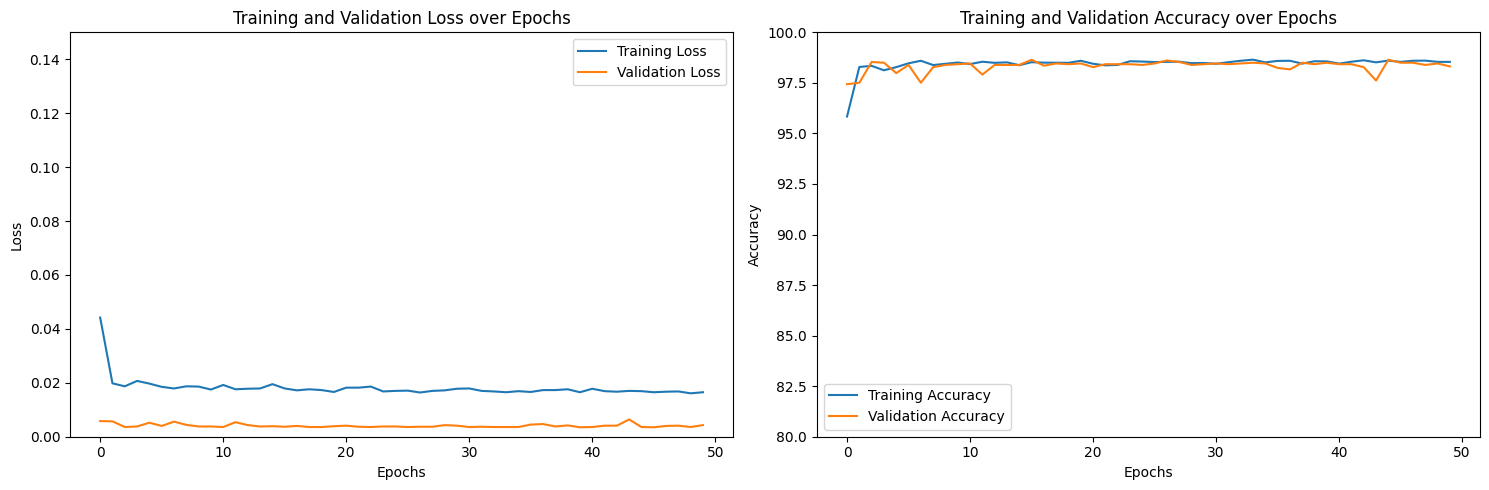

In [56]:
ig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

axs[0].plot(total_loss_train_plot, label='Training Loss')
axs[0].plot(total_loss_validation_plot, label='Validation Loss')
axs[0].set_title('Training and Validation Loss over Epochs')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].set_ylim([0, 0.15])
axs[0].legend()

axs[1].plot(total_acc_train_plot, label='Training Accuracy')
axs[1].plot(total_acc_validation_plot, label='Validation Accuracy')
axs[1].set_title('Training and Validation Accuracy over Epochs')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].set_ylim([80, 100])
axs[1].legend()

plt.tight_layout()

plt.show()

In [58]:
%pip install opendatasets --quiet


Note: you may need to restart the kernel to use updated packages.
